In [183]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
import numpy as np
import scipy
import scipy.linalg
import scipy.stats
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import cma
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [185]:
def optimize(func, x0, sigma, maxfevals = 1000, popsize = None, weights = None, generations_plot = False):
    cma_es = CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    cntr = -1
    if generations_plot:
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize=(15,10))
        l = [ax1,ax2,ax3,ax4,ax5,ax6]
    while not cma_es.terminate():
        cntr+=1
        x = cma_es.sample()
        f_eval = func(x)
        if cntr < 6 and generations_plot:
            I = np.argsort(f_eval)
            x = x[I]
            f_eval = f_eval[I]
            x_good = x[:cma_es.mu][:,0]
            y_good = x[:cma_es.mu][:,1]
            x_bad = x[cma_es.mu:][:,0]
            y_bad = x[cma_es.mu:][:,1]
            old_C = cma_es.C
            old_mean = cma_es.xmean
            cma_es.update(x, f_eval)
            res.append(cma_es.best)
            new_C = cma_es.C
            new_mean = cma_es.xmean
            # plot
            x_min, x_max = min(x[:][:,0]), max(x[:][:,0])
            y_min, y_max = min(x[:][:,1]), max(x[:][:,1])
            X, Y = np.meshgrid(np.linspace(x_min*0.95,x_max*1.05,20),np.linspace(y_min*0.95,y_max*1.05,40))
            Z = - func(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
            l[cntr%6].contour(X, Y, Z, 50)
            l[cntr%6].set_title('Generation {}'.format(cntr))
            l[cntr%6].scatter(x_good, y_good)
            l[cntr%6].scatter(x_bad, y_bad)
            add_ellipse(l[cntr%6], old_C, old_mean, 'tab:orange')
            add_ellipse(l[cntr%6], new_C, new_mean, 'b')
        else:
            cma_es.update(x, f_eval)
            res.append(cma_es.best)
        if cntr % 100 == 0:
            print(f"Iteration {cntr:5d}:   {cma_es.counteval}   {res[-1][1]} ")
    if generations_plot:
        for ax in fig.get_axes():
            ax.label_outer()
    return res



# Funkcje celu

In [186]:
def sphere_function(X):
    return np.sum(X**2, axis=1)

In [187]:
def ellipsoid_function(X, a=2):
    n = X.shape[-1]
    return np.sum((a**(np.arange(n)/(n-1)))*X**2, axis=1)

In [188]:
def rastrigin_function(X):
    return 10.0 * X.shape[1] + np.sum(X**2, axis=1) - 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [189]:
def schwefel_function(X):
    return 418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [190]:
def griewank_function(X):
    return 1 + np.sum(X**2 / 4000, axis=1) - np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [191]:
def cigar_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = X[:,0]**2
    x2 = np.sum(a*X[:,1:]**2, axis = 1)
    return x1+x2

In [192]:
def discus_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [193]:
def cigar_discus_function(X, a = 2):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum((a**0.5)*X[:,1:-1]**2, axis = 1)
    x3 = X[:,-1]**2
    return x1+x2+x3

In [194]:
def parab_ridge_function(X):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = - X[:,0]
    x2 = 100*np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [195]:
def two_axes_function(X, a = 5):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    n = X.shape[-1]
    k = n//2
    x1 = np.sum(a*X[:,:k]**2, axis = 1)
    x2 = np.sum(X[:,k:]**2, axis = 1)
    return x1+x2

In [196]:
"""
xNES from 'Natural Evolution Strategies'
if n_jobs>1, I suggest using "export MKL_NUM_THREADS=1"
See at the bottom (under __main__) for an example of usage
"""
import joblib
import random
import numpy as np

import scipy as sp
from scipy import (dot, eye, randn, asarray, array, trace, log, exp, sqrt, mean, sum, argsort, square, arange)
from scipy.stats import multivariate_normal, norm
from scipy.linalg import (det, expm)

class XNES(object):
    def __init__(self, f, mu, amat,
                 eta_mu=1.0, eta_sigma=None, eta_bmat=None,
                 npop=None, use_fshape=True, use_adasam=True, patience=100, n_jobs=1):
        self.f = f
        self.mu = mu
        self.eta_mu = eta_mu
        self.use_adasam = use_adasam
        self.n_jobs = n_jobs

        dim = len(mu)
        sigma = abs(det(amat))**(1.0/dim)
        bmat = amat*(1.0/sigma)
        self.dim = dim
        self.sigma = sigma
        self.bmat = bmat

        # default population size and learning rates
        npop = int(4 + 3*log(dim)) if npop is None else npop
        eta_sigma = 3*(3+log(dim))*(1.0/(5*dim*sqrt(dim))) if eta_sigma is None else eta_sigma
        eta_bmat = 3*(3+log(dim))*(1.0/(5*dim*sqrt(dim))) if eta_bmat is None else eta_bmat
        self.npop = npop
        self.eta_sigma = eta_sigma
        self.eta_bmat = eta_bmat

        # compute utilities if using fitness shaping
        if use_fshape:
            a = log(1+0.5*npop)
            utilities = array([max(0, a-log(k)) for k in range(1,npop+1)])
            utilities /= sum(utilities)
            utilities -= 1.0/npop           # broadcast
            utilities = utilities[::-1]  # ascending order
        else:
            utilities = None
        self.use_fshape = use_fshape
        self.utilities = utilities

        # stuff for adasam
        self.eta_sigma_init = eta_sigma
        self.sigma_old = None

        # logging
        self.fitness_best = 100000000
        self.mu_best = None
        self.done = False
        self.counter = 0
        self.patience = patience
        self.history = {'eta_sigma':[], 'sigma':[], 'fitness':[]}

        # do not use these when hill-climbing
        if npop == 1:
            self.use_fshape = False
            self.use_adasam = False

    def step(self, niter):
        """ xNES """
        f = self.f
        mu, sigma, bmat = self.mu, self.sigma, self.bmat
        eta_mu, eta_sigma, eta_bmat = self.eta_mu, self.eta_sigma, self.eta_bmat
        npop = self.npop
        dim = self.dim
        sigma_old = self.sigma_old

        eyemat = eye(dim)

        with joblib.Parallel(n_jobs=self.n_jobs) as parallel:

            for i in range(niter):
                s_try = randn(npop, dim)
                z_try = mu + sigma * dot(s_try, bmat)     # broadcast

                f_try = parallel(joblib.delayed(f)(z) for z in z_try)
                f_try = asarray(f_try)

                # save if best
                fitness = mean(f_try)
                if fitness - 1e-8 > self.fitness_best:
                    self.fitness_best = fitness
                    self.mu_best = mu.copy()
                    self.counter = 0
                else: self.counter += 1
                if self.counter > self.patience:
                    self.done = True
                    return

                isort = argsort(f_try)
                f_try = f_try[isort]
                s_try = s_try[isort]
                z_try = z_try[isort]

                u_try = self.utilities if self.use_fshape else f_try

                if self.use_adasam and sigma_old is not None:  # sigma_old must be available
                    eta_sigma = self.adasam(eta_sigma, mu, sigma, bmat, sigma_old, z_try)

                dj_delta = dot(u_try, s_try)
                dj_mmat = dot(s_try.T, s_try*u_try.reshape(npop,1)) - sum(u_try)*eyemat
                dj_sigma = trace(dj_mmat)*(1.0/dim)
                dj_bmat = dj_mmat - dj_sigma*eyemat

                sigma_old = sigma

                # update
                mu += eta_mu * sigma * dot(bmat, dj_delta)
                sigma *= exp(0.5 * eta_sigma * dj_sigma)
                bmat = dot(bmat, expm(0.5 * eta_bmat * dj_bmat))

                # logging
                self.history['fitness'].append(fitness)
                self.history['sigma'].append(sigma)
                self.history['eta_sigma'].append(eta_sigma)

        # keep last results
        self.mu, self.sigma, self.bmat = mu, sigma, bmat
        self.eta_sigma = eta_sigma
        self.sigma_old = sigma_old

    def adasam(self, eta_sigma, mu, sigma, bmat, sigma_old, z_try):
        """ Adaptation sampling """
        eta_sigma_init = self.eta_sigma_init
        dim = self.dim
        c = .1
        rho = 0.5 - 1./(3*(dim+1))  # empirical

        bbmat = dot(bmat.T, bmat)
        cov = sigma**2 * bbmat
        sigma_ = sigma * sqrt(sigma*(1./sigma_old))  # increase by 1.5
        cov_ = sigma_**2 * bbmat

        p0 = multivariate_normal.logpdf(z_try, mean=mu, cov=cov)
        p1 = multivariate_normal.logpdf(z_try, mean=mu, cov=cov_)
        w = exp(p1-p0)

        # Mann-Whitney. It is assumed z_try was in ascending order.
        n = self.npop
        n_ = sum(w)
        u_ = sum(w * (np.arange(n)+0.5))

        u_mu = n*n_*0.5
        u_sigma = sqrt(n*n_*(n+n_+1)/12.)
        cum = norm.cdf(u_, loc=u_mu, scale=u_sigma)

        if cum < rho:
            return (1-c)*eta_sigma + c*eta_sigma_init
        else:
            return min(1, (1+c)*eta_sigma)

In [197]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        #if np.mod(t, log_frequency) == 0:
        #    print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

Sphere function

In [198]:
from scipy import (dot, eye, randn, asarray, array, trace, log, exp, sqrt, mean, sum, argsort, square, arange)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

def f(x):                   # sin(x^2+y^2)/(x^2+y^2)
    r = np.sum(np.square(x))
    assert r > 0
    return -r
    #return sp.sin(r)/r

d=2


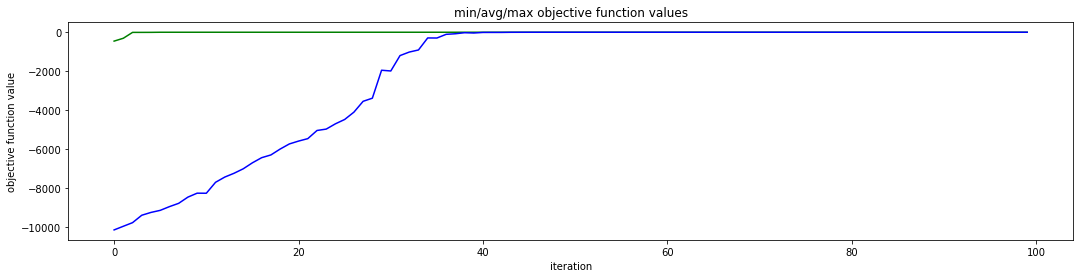

d=10


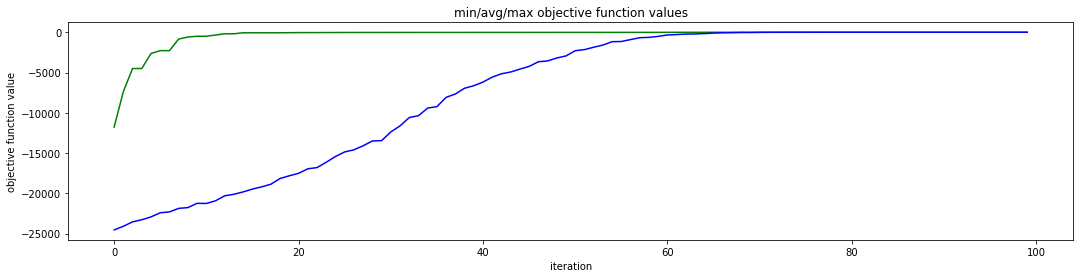

d=20


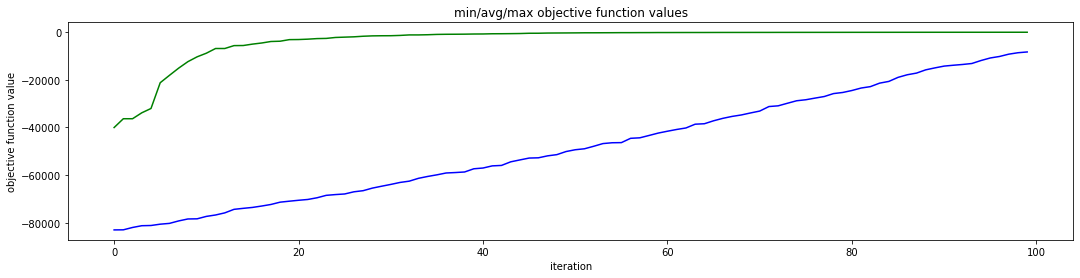

d=50


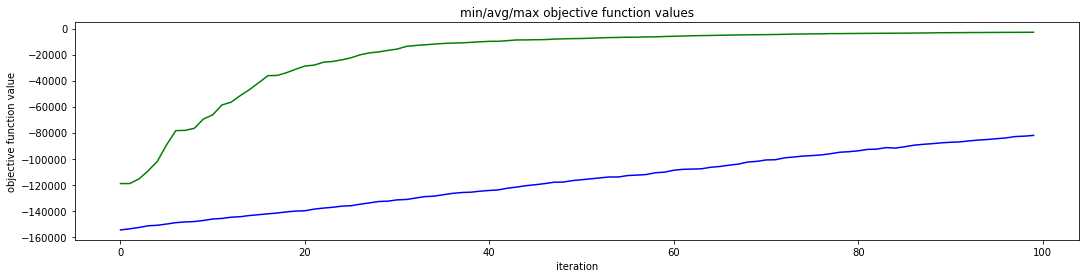

In [199]:
import warnings
warnings.filterwarnings('ignore')
for d in [2,10,20,50]:
    print("d={}".format(d))
    N = 10
    T = 100

    x0 = np.random.randint(-100,100,d)
    mu = np.random.randint(-100,100,d).astype(float) # a bad init guess
    amat = np.eye(d)
    xnes = XNES(f, mu, amat, npop=N, use_adasam=True, eta_bmat=0.01, eta_sigma=.1, patience=T)
    xnes.step(T)
    res = xnes.history['fitness']
    y = np.array(res)
#     T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

In [200]:
from scipy import (dot, eye, randn, asarray, array, trace, log, exp, sqrt, mean, sum, argsort, square, arange)
def objective_function_F1(X):
    return np.sin(np.sum(X**2, axis=1))/np.sum(X**2, axis=1)

def f(x):                   # sin(x^2+y^2)/(x^2+y^2)
    r = sum(square(x))
    return sp.sin(r)/r

d=2


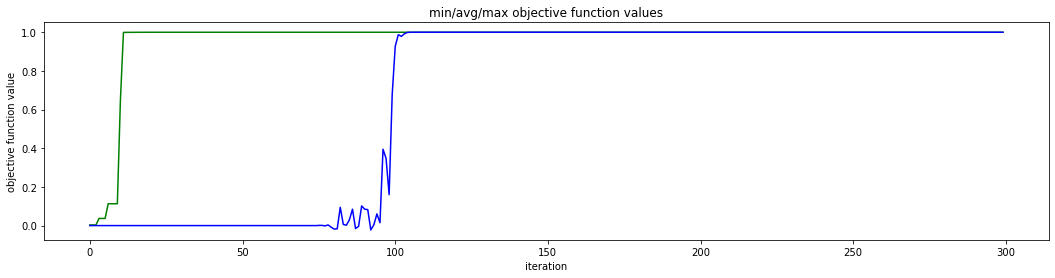

In [201]:
import warnings
warnings.filterwarnings('ignore')
for d in [2]:
    print("d={}".format(d))
    N = 10
    T = 300

    x0 = np.random.randint(-100,100,d)
    mu = np.random.randint(-100,100,d).astype(float) # a bad init guess
    amat = np.eye(d)
    xnes = XNES(f, mu, amat, npop=N, use_adasam=True, eta_bmat=0.01, eta_sigma=.1, patience=T)
    xnes.step(T)
    res = xnes.history['fitness']
    y = np.array(res)
#     T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

Rastrigin function

In [202]:
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

d=2


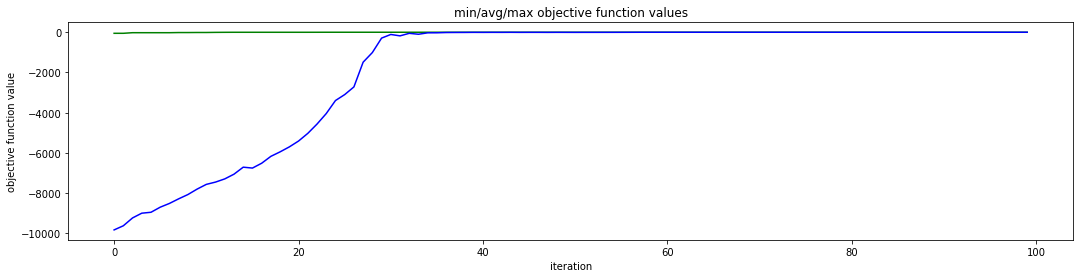

d=10


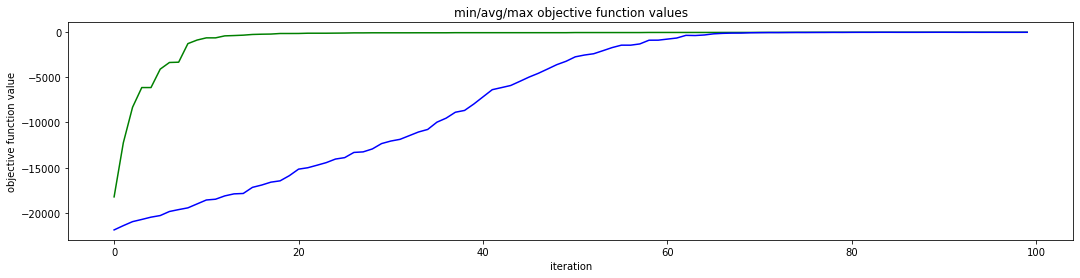

d=20


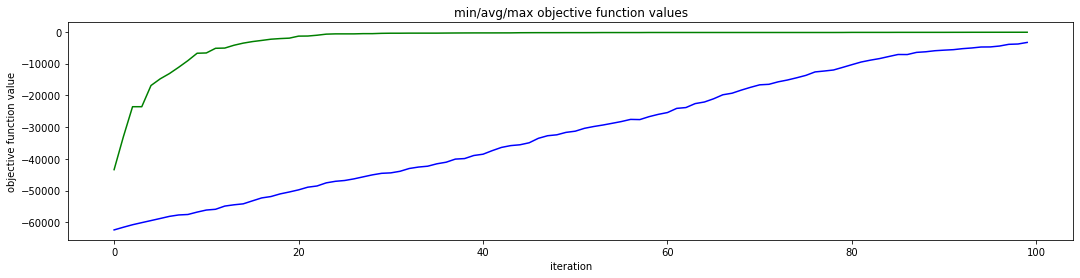

d=50


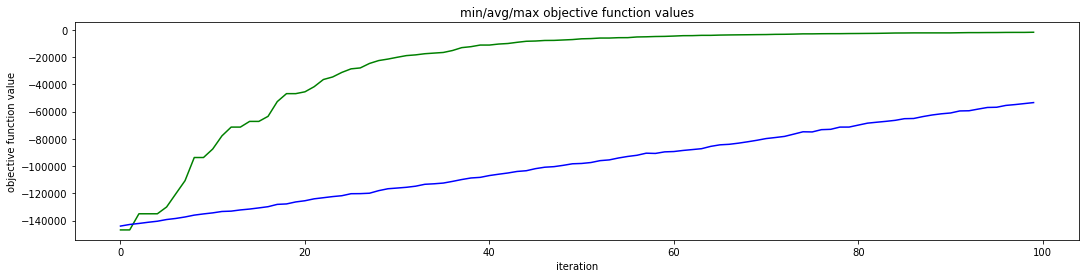

In [203]:
import warnings
warnings.filterwarnings('ignore')
for d in [2,10,20,50]:
    def f(X):
        return - 10.0 * d - sum(square(X)) + 10.0 * sum(sp.cos(sp.cos(2 * np.pi * X)))
    
    print("d={}".format(d))
    N = 10
    T = 100

    x0 = np.random.randint(-100,100,d)
    mu = np.random.randint(-100,100,d).astype(float) # a bad init guess
    amat = np.eye(d)
    xnes = XNES(f, mu, amat, npop=N, use_adasam=True, eta_bmat=0.01, eta_sigma=.1, patience=T)
    xnes.step(T)
    res = xnes.history['fitness']
    y = np.array(res)
#     T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

Schwefel function

In [220]:
def objective_function_F7(X):
    if np.any(np.abs(X) > 500):
        return 1000
    return - (418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1))

d=2


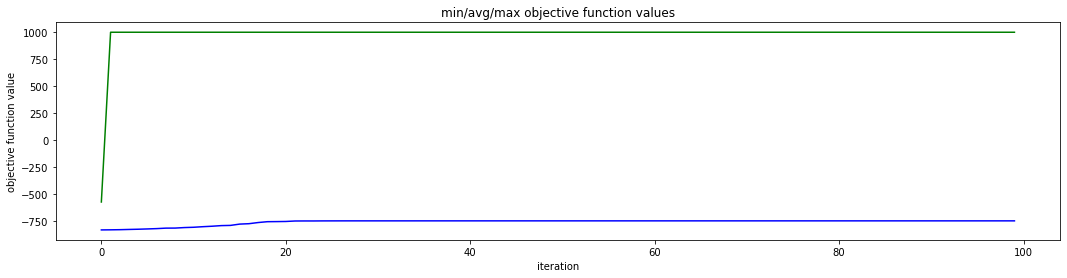

d=10


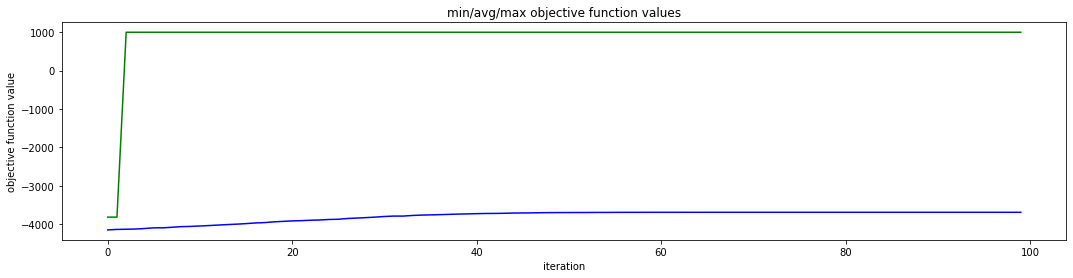

d=20


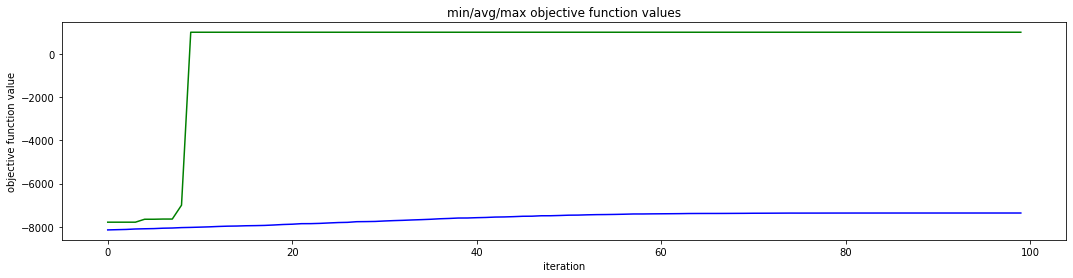

d=50


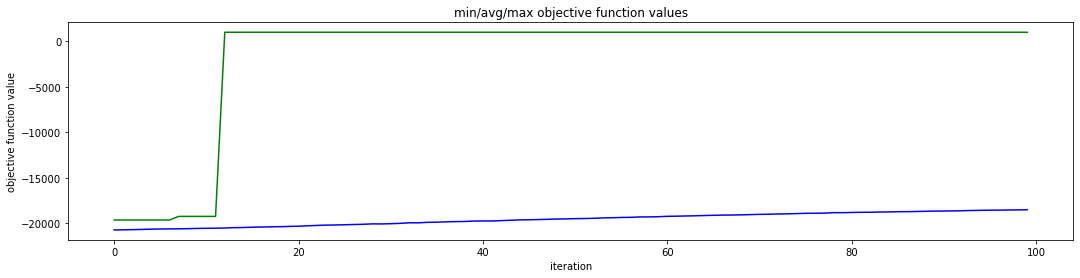

In [221]:
import warnings
warnings.filterwarnings('ignore')
for d in [2,10,20,50]:
    def f(X):
        X = np.array(X)
        if np.any(np.abs(X) > 500):
            return 1000
        return - (418.9829 * X.shape[0] - np.sum(X * np.sin(np.sqrt(np.abs(X)))))
        #return - (418.9829 * d - sum(X * sp.sin(sp.sqrt(sp.absolute(X)))))
    
    print("d={}".format(d))
    N = 10
    T = 100

    x0 = np.random.randint(-100,100,d)
    mu = np.random.randint(-100,100,d).astype(float) # a bad init guess
    amat = np.eye(d)
    xnes = XNES(f, mu, amat, npop=N, use_adasam=True, eta_bmat=0.01, eta_sigma=.1, patience=T)
    xnes.step(T)
    res = xnes.history['fitness']
    y = np.array(res)
#     T = len(y)
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F7, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 1], 'g-')
    plt.plot(y, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()